# Figure 1 Final

Notebook to make figure 1 for ms <br>
by Cascade Tuholske 2020.02.23

In [2]:
#### Depdencies 
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

In [12]:
#### Load Data

# file paths
DATA_IN = "/home/cascade/projects/UrbanHeat/data/"  # Note: Need ?dl=1 to make sure this file gets read correctly
FIG_OUT = "/home/cascade/projects/UrbanHeat/figures/"
FN_IN = 'processed/All_data_HI406_figdata.csv'
#FN_IN = '/home/cascade/projects/UrbanHeat/data/processed/oldworkflow/All_data_Raw406_es_final_pdayadd.csv'

df_data = pd.read_csv(DATA_IN+FN_IN)

In [13]:
# Check it
df_data.head()

,Unnamed: 0,ID_HDC_G0,year,total_days,P,P1983,P2016,people_days,people_days_heat,people_days_pop
0,0,22,1983,2,52064.452435,52064.452435,73006.671133,0.000104,0.000104,0.0
1,1,26,1983,1,194088.886834,194088.886834,268055.635628,0.000194,0.000194,0.0
2,2,27,1983,1,80540.779940,80540.779940,93335.494324,0.000081,0.000081,0.0
3,3,28,1983,9,59320.971209,59320.971209,91449.606255,0.000534,0.000534,0.0
4,4,29,1983,8,336518.836621,336518.836621,533318.453653,0.002692,0.002692,0.0


In [14]:
#### Drop 40 cities where P1983 == 40
print(len(HI_STATS))
HI_STATS = HI_STATS[HI_STATS['P1983'] > 0]
print(len(HI_STATS))

#### Drop cities with only one Tmax Day in 1983 and none else because you cannot regress them
drop_list = [2543, 2560, 3667, 3669, 6122, 6156] # city IDS
HI_STATS= HI_STATS[~HI_STATS['ID_HDC_G0'].isin(drop_list)]
print(len(HI_STATS))

392972
391612


In [5]:
#### Regressions, no intercept addition is needed because we're using SK LEARN HERE 

def lm_func(df, col, scale):
    
    "simple linear model of a time series data, returns coef"
    
    # Get Data
    X_year = np.array(df.groupby('year')['ID_HDC_G0'].mean().index).reshape((-1, 1))
    Y_stats = np.array(df.groupby('year')[col].sum()).reshape((-1, 1))

    # Add Intercept
    X_year_2 = sm.add_constant(X_year)

    # Regress
    model = sm.OLS(Y_stats, X_year_2).fit() 
        
    coef = int(model.params[1]*scale)
    #coef = int(coef)
            
    # R2 and P
    r2 = model.rsquared_adj
    p = model.pvalues[0]
    
    return coef, round(r2, 2), round(p, 3)

Text(2.56, 0.85, '1.2B increase in people-\ndays per year')

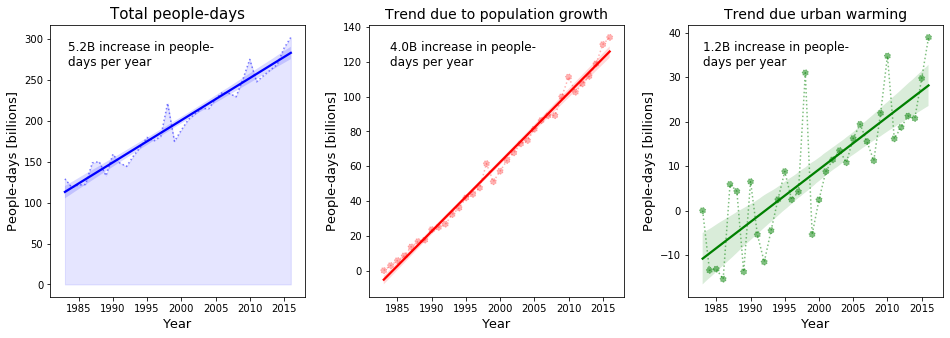

In [10]:
#### Make Figure & Save it

fig, axs = plt.subplots(1, 3, figsize = (16, 5), sharex=True)
ws = 0.25
fig.subplots_adjust(wspace=ws)

## PLOT 1 - People Days
color = 'blue'
data = df_data.groupby('year')['people_days'].sum() 
years = list(data.index)
axs[0].plot(data, color = color, linestyle = ':', alpha = 0.5)
axs[0].fill_between(years, data, color = color, alpha = 0.1, label='_nolegend_')
sns.regplot(years, data, color = color, ax = axs[0], scatter = False, truncate = True)
axs[0].set_title('Total people-days', size = 15 )
axs[0].set_ylabel('People-days [billions]', fontsize = 13)
axs[0].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(df_data, 'people_days', 10**3)
text = str(round(coef/1000, 1))+'B increase in people-\ndays per year'# ($R^2$=' + str(r2) + ')*'
axs[0].text(0.07, .85, text, transform=axs[0].transAxes, size=12)

#2 PLOT 2 - People Days delta pop x days
color = 'red'
data = df_data.groupby('year')['people_days_pop'].sum() 
axs[1].scatter(years, data, color = color, linestyle = ':', alpha = 0.3)
axs[1].plot(data, color = color, linestyle = ':', alpha = 0.3)
sns.regplot(years, data, color = color, ax = axs[1], scatter = False, truncate = True)
axs[1].set_title('Trend due to population growth', size = 14)
axs[1].set_ylabel('People-days [billions]', fontsize = 13)
axs[1].set_xlabel('Year', fontsize = 13)

# Add text
coef, r2, p = lm_func(df_data, 'people_days_pop', 10**3)
text = str(round(coef/1000, 1))+'B increase in people-\ndays per year'# ($R^2$=' + str(r2) + ')*'
axs[1].text(1.25+.08, .85, text, transform=axs[0].transAxes, size=12)

## PLOT 3 - People Days due to heat
color = 'green'
data = df_data.groupby('year')['people_days_heat'].sum()
pdays83 = data.get(data.index[0])
data = data - pdays83
years = list(data.index)
axs[2].scatter(years, data, color = color, linestyle = ':', alpha = 0.5)
axs[2].plot(data, color = color, linestyle = ':', alpha = 0.5)
sns.regplot(years, data, color = color, ax = axs[2], scatter = False, truncate = True)
axs[2].set_title('Trend due to urban warming', size = 14)
axs[2].set_xlabel('Year', fontsize = 13)
axs[2].set_ylabel('People-days [billions]', fontsize = 13)

# Add text
coef, r2, p = lm_func(df_data, 'people_days_heat', 10**3)
text = str(round(coef/1000, 1))+'B increase in people-\ndays per year' # ($R^2$=' + str(r2) + ')*'
axs[2].text(1.25*2-0.04+.1, .85, text, transform=axs[0].transAxes, size=12,)



# Set y-axis
# for ax in fig.get_axes():
#     ax.label_outer()

#plt.savefig(FIG_OUT+'FIG1.png')



In [ ]:
1 / (3+1) * 100